<a href="https://colab.research.google.com/github/donw7/neural_activity_models_DNNs/blob/main/DNN_decoding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Decoding decision-making behavior from neural activity
This is a comparison of statistical models vs. deep neural networks (DNNs), their performances across different conditions and with various hyperparameters and types of neural data enabled by recent advances in cellular-resolution, brain-wide imaging.

## Hypotheses:
1. Decision-making behavior can be predicted reasonably well from information encoded in neural activity, even with small datasets
2. DNNs outperform statistical models but are prone to overfitting and require additional considerations, e.g. regularization

## Procedures:
1. Simulate neural data as validation of models to be used later with more complicated real neural data
2. Apply logistic regression
3. Apply recurrent neural networks (RNNs), LSTM, and XGBoost
4. Compare DNNs to logistic regression
5. Experimentation with optimizing hyperparameters

## Results & Conclusions summary:
- Early evidence that complicated decision-making behavior can be predicted from information encoded in neural activity, and that multi-regional coordination is involved
- XGBoost appears to be the best performing (67% accuracy vs. 30% expected by chance). Don't want to overinterpret results biologically via differential DNN architectures, but, speculatively, if XGB outperforms it may suggest that time dependencies and hidden states may play a less important role in brain-wide dynamics.
- Alternatively, this could also be due to simply the nature of dataset with sparse spikes (to address this, can conduct analysis on a different type of data, such as EEG or calcium imaging), or model assumptions regarding this data more appropriate
- Unclear whether other DNNs outperform
- Interestingly, this suggests cellular information integrated across brain regions may work together for decision-making, a phenomenon that was previously technologically inaccessible

## Future directions:
- further validation
- more systmatic hyperparameter tuning, e.g. grid search
- compare with other models, e.g. KNNs, SVM
- generalize to other types of data and conditions, such as EEG data in decision-making tasks
- prediction of real-time dynamics and how this may affect the performance of DNNs, e.g. less structural and more sequential information

## Acknowledgements:
- basic notebook adapted from KordingLab, with added data, analyses, and custom scripts, visualizations
- real neural activity data from Steinmetz et al., 2019

# Background
Neuropixels recordings from Steinmetz et al., 2019 of mice engaging in visual decision-making task. Probes are targeted near visual cortex but as indicated below are distributed brain-wide. Here we will use this rich, already preprocessed data to try to predict choices from 1 s of neural activity prior to choice. 

"Mice earned water rewards by turning a wheel to indicate which of two visual gratings had higher contrast, or by not turning if no stimulus was presented. When stimuli had equal contrast, a left or right choice was rewarded with 50% probability."

Steinmetz, N.A., Zatka-Haas, P., Carandini, M. et al. Distributed coding of choice, action and engagement across the mouse brain. Nature 576, 266–273 (2019).

Paradigm: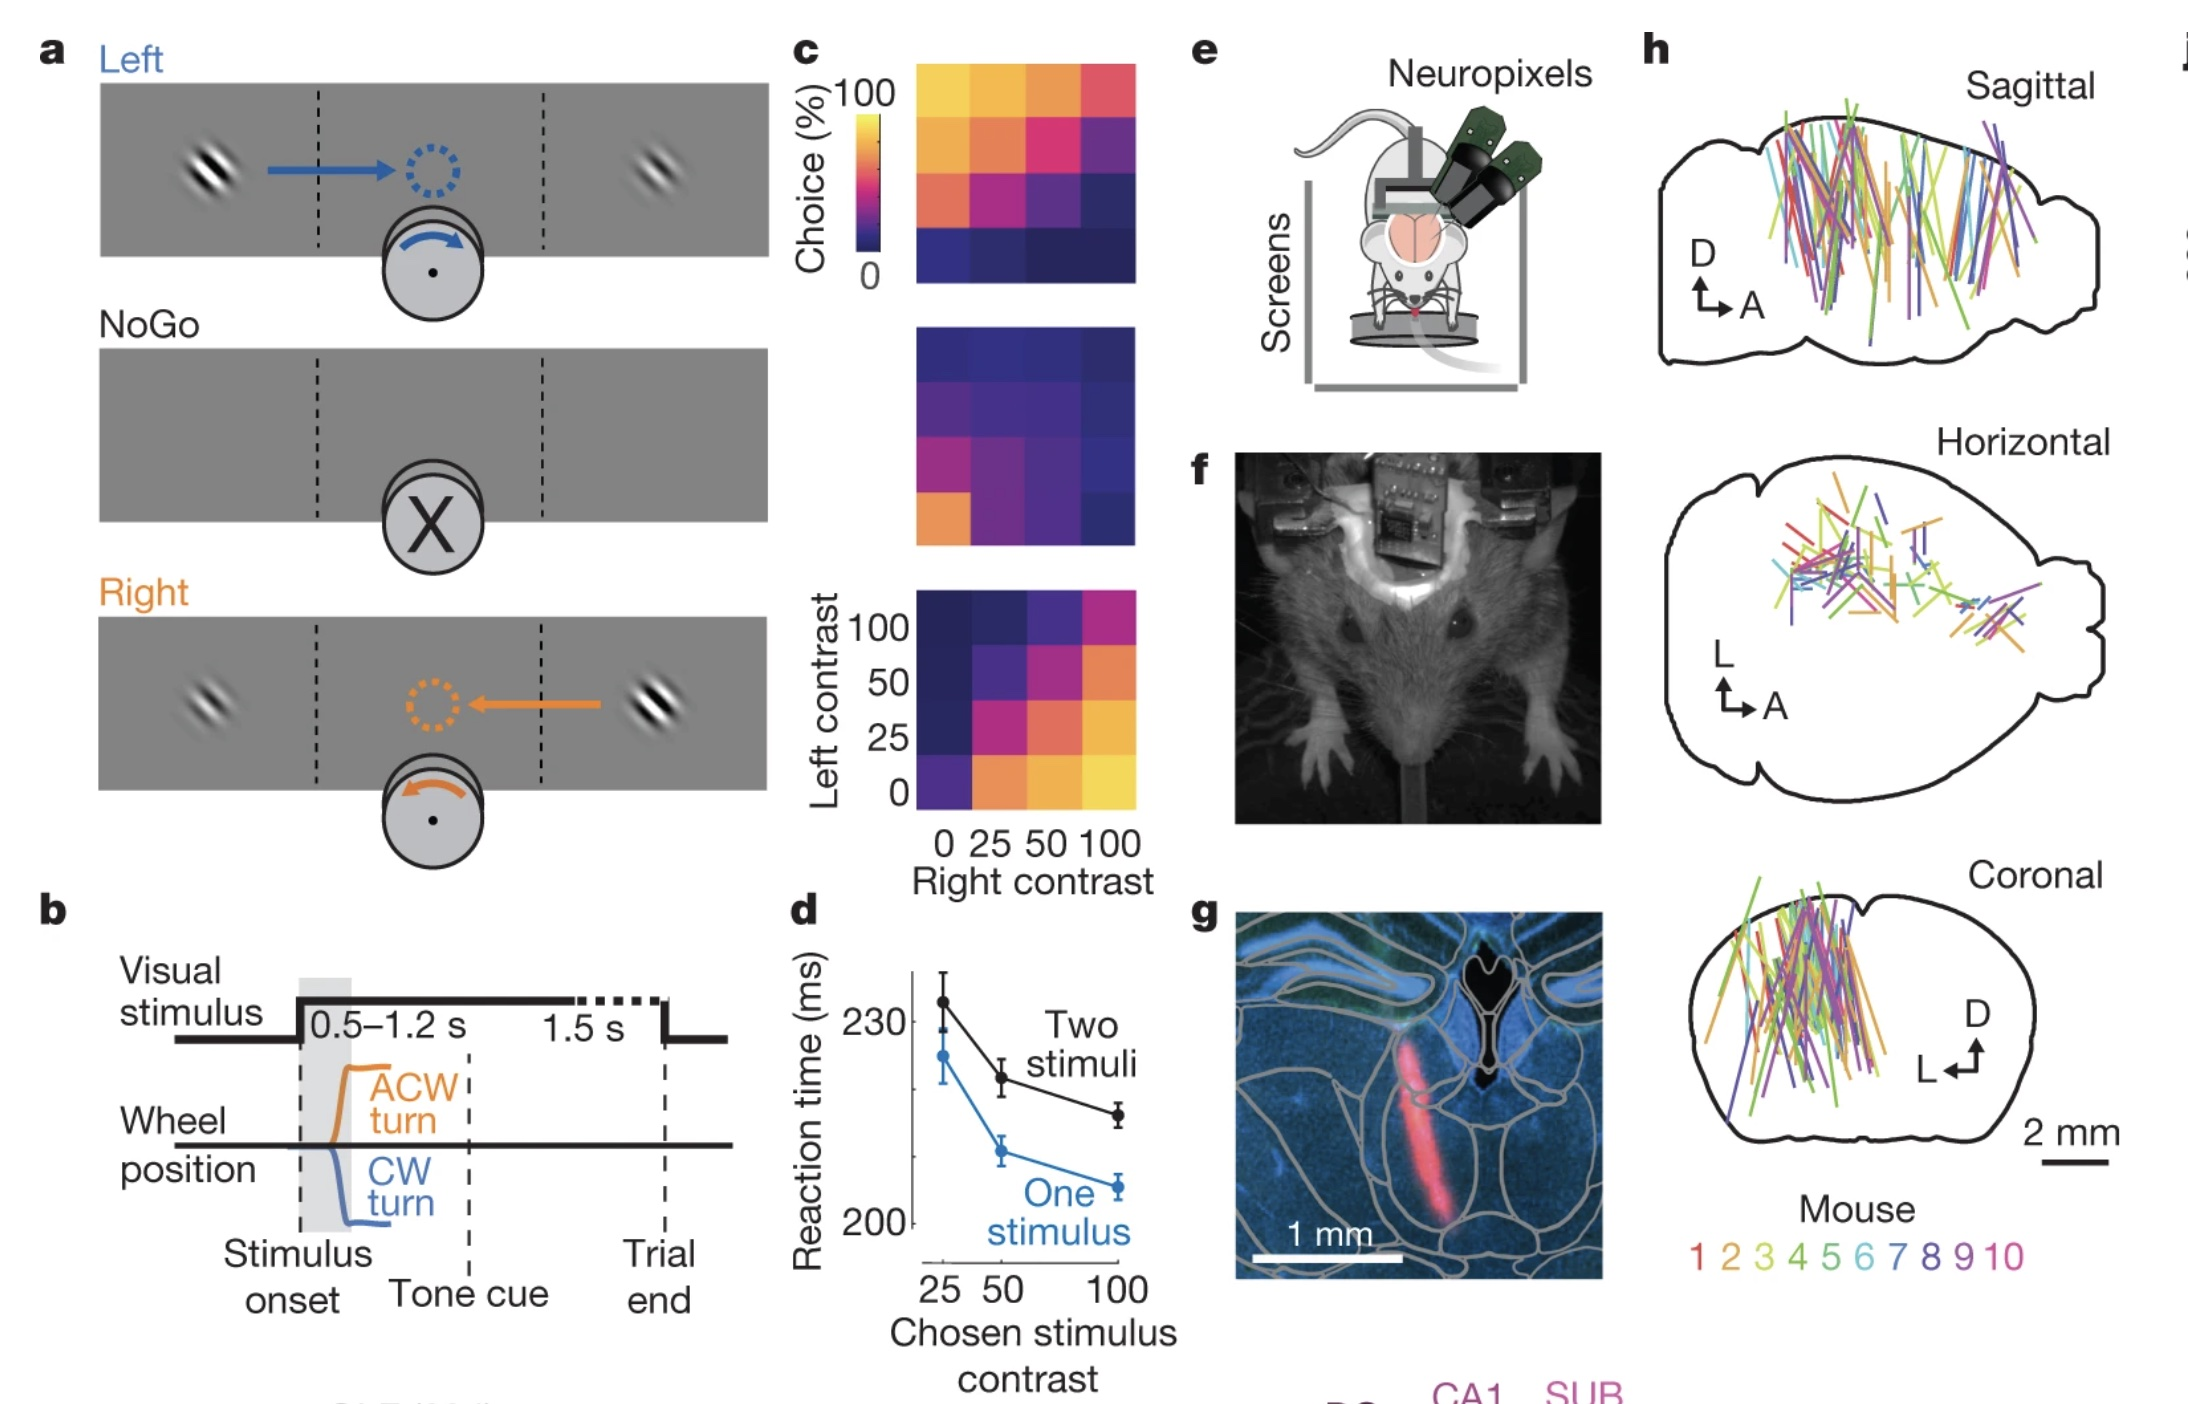

# Set up paths & import modules

### conditional mounting and path personalization

In [2]:
if "google.colab" in str(get_ipython()):
  print("running on colab, mounting")
  from google.colab import drive
  drive.mount("/content/drive")
  
  # personalize to path
  %cd "/content/drive/MyDrive/Colab Notebooks and Projects/neural_activity_models_DNNs-main"
  %ls
else:
  print("not running on colab")



running on colab, mounting
Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks and Projects/neural_activity_models_DNNs-main
Binned_data.zip     generate.py                            __pycache__/
binned_spikes.npy   LICENSE                                README.md
choices.npy         mycrossval.py                          taskData/
decoders.py         myplotfns.py
DNN_decoding.ipynb  neural-sequence_transformers_v2.ipynb


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import random
import warnings

import sklearn
from sklearn import linear_model

!pip install googledrivedownloader
from google_drive_downloader import GoogleDriveDownloader as gdd

In [4]:
# custom modules
import generate
import decoders
warnings.filterwarnings('ignore')
import myplotfns
import mycrossval



/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Download data

In [4]:
# dataset session name: "Cori_2016-12-18"
gdd.download_file_from_google_drive(file_id='1W3TwEtC0Z6Qmbfuz8_AWRiQHfuDb9FIS',
                                    dest_path='./Binned_data.zip',
                                    unzip=True)


In [5]:
binned_spikes = np.load('binned_spikes.npy')
choices = np.load('choices.npy')+1
print(binned_spikes.shape, choices.shape)
print(choices[:10])


(228, 1089, 50) (228,)
[2. 2. 0. 0. 0. 1. 0. 0. 0. 2.]


# Initial vizualization of neural data structure

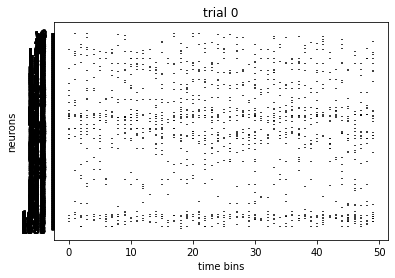

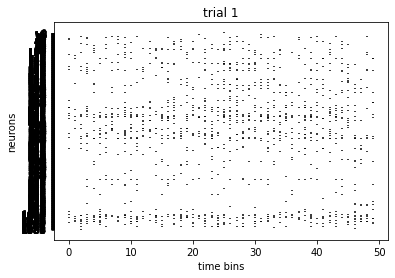

In [6]:
# print binned spikes event plots
displayidx = range(2) # trial indices to display
for di in displayidx:
  df_spikes_trial = pd.DataFrame(binned_spikes[di,:,:].T)
  positions = df_spikes_trial.apply(lambda x: df_spikes_trial.index[x == 1])
  plt.figure(di)
  plt.eventplot(positions, linelengths=2, lineoffsets=1, colors='black')
  plt.yticks(range(positions.index.size), positions.index)
  plt.gca().invert_yaxis()
  plt.ylabel('neurons')
  plt.xlabel('time bins')
  plt.title(f'trial {di}')

There are 228 trials, 1089 neurons, and 50 bins per trial (for a time of 20ms per bin).



# Set up cross validation and regularization

We will set up custom cross validation from scratch in order have more control when comparing models on a iteration to iteration basis, ensuring fairer comparisons. 

## simulate neural data to set up and as validation later
Since the goal is to analyze complicated real neural data, which would be less well-validated and subject to more noisy real world conditions, it would be prudent to start with analysis of simple simulated data to do some quick and dirty testing of regularization and cross validation parameters

Later, we will use this simulated data again as a positive control in order to rule out technical issues either in the data collection or model application process. 

In [7]:
# generate some simulated trial & neural data (drift diffusion model)
n_trials = 250
n_neurons = 10
n_bins_per_trial = 50

# shape n_trials x n_neurons x n_bins
neural_recordings, decisions = generate.neural_data(n_trials,
                                                    n_neurons,
                                                    n_bins_per_trial)

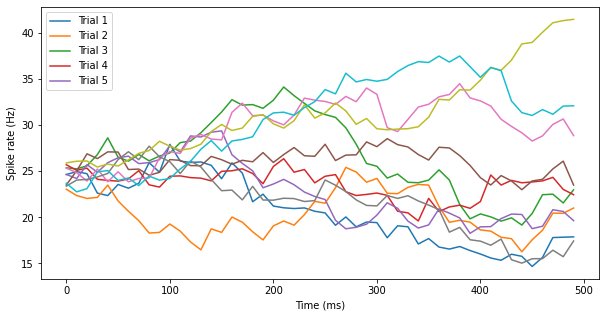

In [8]:
# plot out some trials for one neuron
neuron_id = 0

plt.figure(figsize=(10,5))
plt.plot(np.arange(0,500,10),neural_recordings[:10,neuron_id,:].T)
plt.xlabel("Time (ms)")
plt.ylabel("Spike rate (Hz)")
plt.legend(["Trial {}".format(i) for i in range(1,6)])

## obtain k-fold cross validation splits

In [9]:
# flatten
X = np.reshape(neural_recordings, (n_trials,-1))

(training_X, training_Y), (val_X, val_Y) = mycrossval.get_test_train_splits(X, decisions)

## no regularization

Fold 0 of 5
   Validation accuracy of 0.92


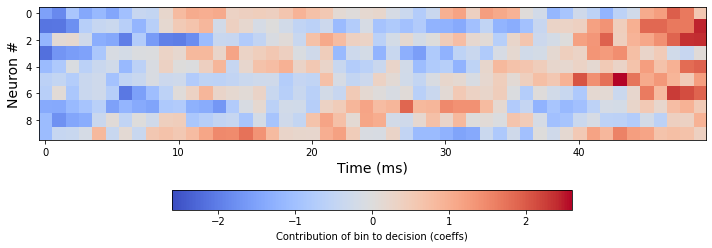

Fold 1 of 5
   Validation accuracy of 0.84


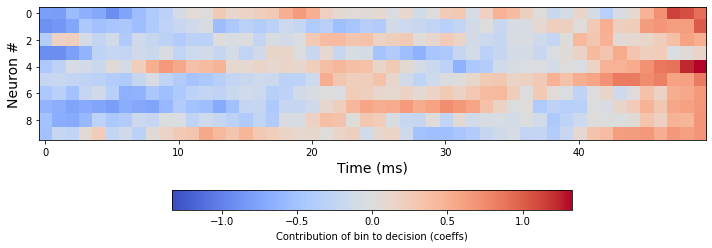

Fold 2 of 5
   Validation accuracy of 0.88


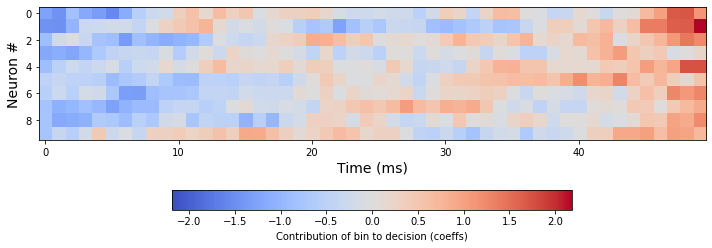

Fold 3 of 5
   Validation accuracy of 0.86


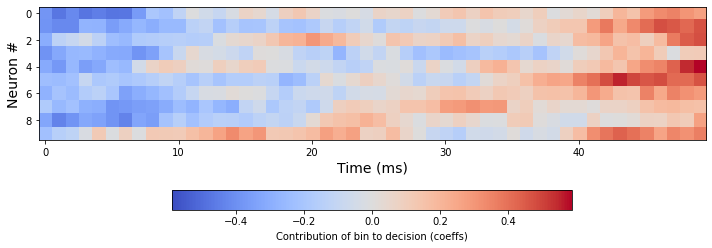

Fold 4 of 5
   Validation accuracy of 0.88


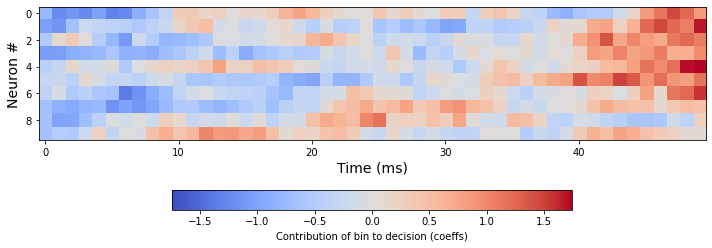

Mean validation accuracy: 0.876


In [10]:
scores = []

# Iterate through the k=5 folds
for fold in range(5):
  print("Fold {} of 5".format(fold))
  
  training_Xi = training_X[fold]
  training_Yi = training_Y[fold]
  
  val_Xi = val_X[fold]
  val_Yi = val_Y[fold]
  
  # re-initialize the logistic regression model
  logreg_model = linear_model.LogisticRegression(penalty='none', solver = 'lbfgs',
                                               max_iter = 1000)
  # fit and score on training
  logreg_model.fit(training_Xi, training_Yi)
  logreg_model.score(training_Xi, training_Yi)

  # score on the validation data
  accuracy = logreg_model.score(val_Xi, val_Yi)
  scores.append(accuracy)
  
  print("   Validation accuracy of {}".format( accuracy ))
  
  myplotfns.plot_coefs(logreg_model, n_neurons, n_bins_per_trial)
  
print("Mean validation accuracy: {}".format(np.mean(scores)))

Accuracy strangely high but will see anyway

## experiment with regularization
Small datasets are especially prone to outsized weighting of noise or outliers, would like to implement regularization and compare for any initially obvious anomalies. 

### try initial value

Fold 0 of 5
   Validation accuracy of 0.92


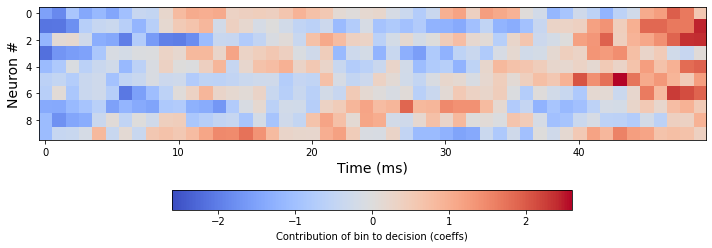

Fold 1 of 5
   Validation accuracy of 0.84


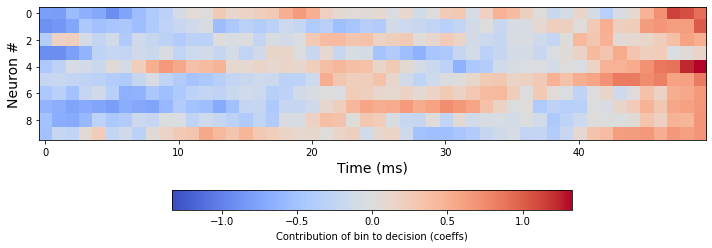

Fold 2 of 5
   Validation accuracy of 0.88


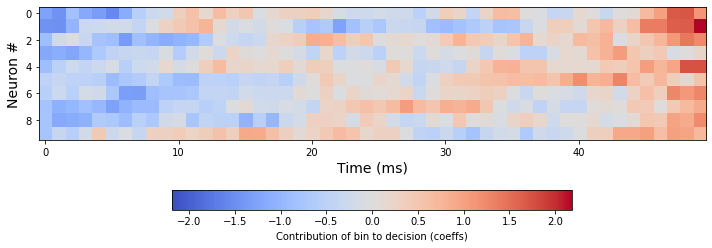

Fold 3 of 5
   Validation accuracy of 0.86


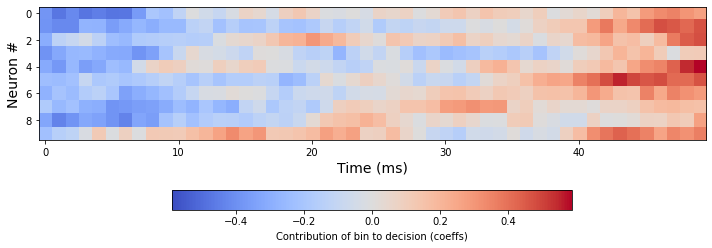

Fold 4 of 5
   Validation accuracy of 0.88


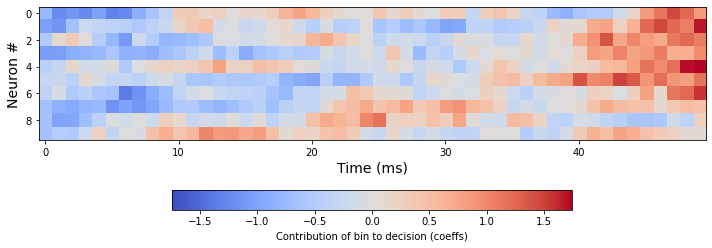

Mean validation accuracy: 0.876


In [11]:
scores = []

# Iterate through the k=5 folds
for fold in range(5):
  print("Fold {} of 5".format(fold))
  
  training_Xi = training_X[fold]
  training_Yi = training_Y[fold]
  
  val_Xi = val_X[fold]
  val_Yi = val_Y[fold]
  
  # re-initialize the logistic regression model
  logreg_model = linear_model.LogisticRegression(penalty='none', solver = 'lbfgs',
                                               max_iter = 1000, C=1e-6)
  # fit and score on training
  logreg_model.fit(training_Xi, training_Yi)
  logreg_model.score(training_Xi, training_Yi)

  # score on the validation data
  accuracy = logreg_model.score(val_Xi, val_Yi)
  scores.append(accuracy)
  
  print("   Validation accuracy of {}".format( accuracy ))
  
  myplotfns.plot_coefs(logreg_model, n_neurons, n_bins_per_trial)
  
print("Mean validation accuracy: {}".format(np.mean(scores)))

This regularization value did not seem to make much of a difference.

### Test a range of regularization penalties, 'C'


In [12]:
# logarithmic schedule of Cs. 
Cs_to_test = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3]

# flatten
training_X_flat = np.reshape(training_X, (len(training_X),-1)) # keep first dim, flatten rest
training_Y_flat = np.reshape(training_Y, (len(training_Y),-1))

validation_accuracy_vs_C = []
for C in Cs_to_test:
  
  # get the mean score on k-fold cross-validation using your function above
  mean_validation_accuracy = mycrossval.get_kfold_validation_score(X, decisions, C)
  
  validation_accuracy_vs_C.append(mean_validation_accuracy)
  

(0.8, 1.0)

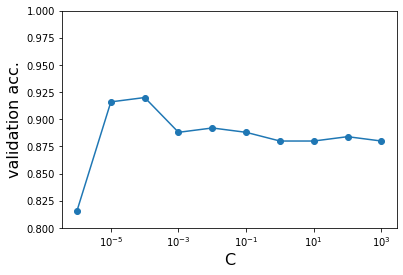

In [13]:
# plot
plt.semilogx(Cs_to_test, validation_accuracy_vs_C,"o-")
plt.xlabel("C",fontsize=16)
plt.ylabel("validation acc.",fontsize=16)
plt.ylim([.8,1])

c=1e-5 appears to be most optimal, appears to make stepwise change but otherwise no major difference. 

# Compare linear and DNN models on neural data

check if GPU ready

In [14]:
!nvidia-smi

Tue Jan 11 21:56:47 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    25W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [51]:
def compute_accuracy(val_spikes, val_choices, model):
  predictions = model.predict(val_spikes)
  accuracy = np.sum(predictions == val_choices) / len(predictions)
  return accuracy

## initial test of training models
An initial quick-and-dirty 1-fold split to test out loading models, train a few epochs, etc.

Fit each of the following decoders:

1.   A Gated Recurrent Unit (`decoders.GRUClassification`)
2.   An LSTM (`decoders.LSTMClassification`)
3.   Gradient boosted trees (XGBoost) (`decoders.XGBoostClassification`)

In [52]:
# split training and validation data
split = int(len(binned_spikes)*4/5)

training_spikes = binned_spikes[:split]
validation_spikes = binned_spikes[split:]

training_choices = choices[:split]
validation_choices = choices[split:]

In [53]:
my_RNN_classifier = decoders.SimpleRNNClassification(units = 100,
                                                    dropout = 0,
                                                    num_epochs =3,
                                                    verbose = 1)

my_RNN_classifier.fit(training_spikes, training_choices)


predictions = my_RNN_classifier.predict(validation_spikes)
accuracy = np.sum(predictions == validation_choices) / float(len(predictions))

print("\n validation accuracy: {} %".format(100*accuracy))


Epoch 1/3
6/6 [==============================] - 5s 701ms/step - loss: 1.0805 - accuracy: 0.4231
Epoch 2/3
6/6 [==============================] - 4s 704ms/step - loss: 0.8462 - accuracy: 0.6209
Epoch 3/3
6/6 [==============================] - 4s 695ms/step - loss: 0.7004 - accuracy: 0.7912

 validation accuracy: 41.30434782608695 %


In [54]:
# GRU
GRU_classifier = decoders.GRUClassification(units = 100,
                                              dropout = .1,
                                              num_epochs = 3,
                                              verbose = 1)

GRU_classifier.fit(training_spikes, training_choices)


Epoch 1/3
6/6 [==============================] - 21s 3s/step - loss: 1.0894 - accuracy: 0.4231
Epoch 2/3
6/6 [==============================] - 19s 3s/step - loss: 1.0458 - accuracy: 0.4725
Epoch 3/3
6/6 [==============================] - 19s 3s/step - loss: 1.0187 - accuracy: 0.4725


In [55]:
# accuracy 
predictions = GRU_classifier.predict(validation_spikes)
accuracy = np.sum(predictions == validation_choices) / len(predictions)
print(accuracy)


0.17391304347826086


In [56]:
#LSTM
LSTM_classifier = decoders.LSTMClassification(units = 100, 
                                              dropout = 0.1,
                                              num_epochs = 3,
                                              verbose = 1)

LSTM_classifier.fit(training_spikes, training_choices)

Epoch 1/3
6/6 [==============================] - 24s 4s/step - loss: 1.0759 - accuracy: 0.4286
Epoch 2/3
6/6 [==============================] - 21s 4s/step - loss: 1.0363 - accuracy: 0.4725
Epoch 3/3
6/6 [==============================] - 21s 4s/step - loss: 1.0160 - accuracy: 0.4725


In [57]:
# accuracy
predictions = LSTM_classifier.predict(validation_spikes)
accuracy = np.sum(predictions == validation_choices) / len(predictions)
print(accuracy)

0.17391304347826086


XGBoost is powerful but does not model time dependencies, thus have to flatten into shape (n_trials, n_neurons x n_time_bins)

In [58]:
# XGBoost
flat_train_data = np.reshape(training_spikes, (len(training_spikes),-1)) # keep first dim, flatten rest
flat_val_data = np.reshape(validation_spikes, (len(validation_spikes),-1))


# now train it like above
XGBoost_classifier = decoders.XGBoostClassification()

XGBoost_classifier.fit(flat_train_data, training_choices)

# accuracy
predictions = XGBoost_classifier.predict(flat_val_data)
accuracy = np.sum(predictions == validation_choices) / len(predictions)
print(accuracy)

0.6739130434782609


Okay, looks like everything is running smoothly as first pass.

Interestingly, XGBoost performing ok already (67% accuracy vs. 30% expected by chance), whereas simple RNN may be variability with only a few epochs and no crossvalidation (40% vs. 30% expected by chance)

## Implement cross validation and regularization
Now will test across models more properly (cv, increase depth, etc.)

In [15]:
# dict to store scores
accuracies_allmodels = {'logreg': [], 'RNN': [], 'GRU': [], 'LSTM': [], 'XGB': []}

In [51]:
# get training and validation data
(training_Xs, training_Ys), (val_Xs, val_Ys) = mycrossval.get_test_train_splits(binned_spikes, choices)

## logistic regression

In [52]:
# 5-fold logistic regression
val_scores = []
for fold in range(5):
    print("Fold {} of 5".format(fold))

    training_X = np.reshape(training_Xs[fold], (len(training_Xs[fold]), -1))
    training_Y = np.reshape(training_Ys[fold], (len(training_Ys[fold]), -1))
    validation_X = np.reshape(val_Xs[fold], (len(val_Xs[fold]), -1))
    validation_Y = np.reshape(val_Ys[fold], (len(val_Ys[fold]), -1)) 

    logreg_model = linear_model.LogisticRegression(penalty='l2',
                                                 solver = 'lbfgs',
                                                 max_iter = 1000,
                                                 C=1e-5)
    # fit and score on training
    logreg_model.fit(training_X, training_Y)
    train_accuracy = logreg_model.score(training_X,training_Y)

    # score on the validation data
    val_accuracy = logreg_model.score(validation_X,validation_Y)
    val_scores.append(val_accuracy)

    print("   training set accuracy of {}".format( train_accuracy ))
    print("   validation set accuracy of {}".format( val_accuracy ))

accuracies_allmodels['logreg'] = np.mean(val_scores) # store
print("Mean validation accuracy: {}".format(np.mean(val_scores)))


Fold 0 of 5
   training set accuracy of 0.7377049180327869
   validation set accuracy of 0.4222222222222222
Fold 1 of 5
   training set accuracy of 0.46994535519125685
   validation set accuracy of 0.17777777777777778
Fold 2 of 5
   training set accuracy of 0.4262295081967213
   validation set accuracy of 0.35555555555555557
Fold 3 of 5
   training set accuracy of 0.73224043715847
   validation set accuracy of 0.8222222222222222
Fold 4 of 5
   training set accuracy of 0.4262295081967213
   validation set accuracy of 0.35555555555555557
Mean validation accuracy: 0.42666666666666664


## set params to be used across RNN, GRU, LSTM

In [19]:
units=500
dropout=0.1
num_epochs=10
verbose=1
n_folds = 5


## simple RNN

In [66]:
# double check paths and updated modules (esp. on colab)
%ls
import importlib
importlib.reload(mycrossval)

Binned_data.zip    DNN_decoding.ipynb  myplotfns.py
binned_spikes.npy  generate.py         neural-sequence_transformers_v2.ipynb
choices.npy        LICENSE             __pycache__/
decoders.py        mycrossval.py       README.md


<module 'mycrossval' from '/content/drive/My Drive/Colab Notebooks and Projects/neural_activity_models_DNNs-main/mycrossval.py'>

In [21]:
# use training wrapper from mycrossval.py
RNN_model_name = "SimpleRNNClassification" 
all_train_accuracy, all_val_accuracy = mycrossval.kfold_train_wrapper(RNN_model_name, binned_spikes, choices,
                                                        n_folds, units, dropout, num_epochs, verbose)
print("all training set accuracy: {}".format(np.mean(all_train_accuracy)))
print("all validation set accuracy: {}".format(np.mean(all_val_accuracy)))
accuracies_allmodels['RNN'] = np.mean(all_val_accuracy) # store

Fold 0 of 5
Epoch 1/10
6/6 [==============================] - 6s 874ms/step - loss: 1.1352 - accuracy: 0.3716
Epoch 2/10
6/6 [==============================] - 5s 864ms/step - loss: 1.1345 - accuracy: 0.4754
Epoch 3/10
6/6 [==============================] - 5s 874ms/step - loss: 1.1768 - accuracy: 0.3443
Epoch 4/10
6/6 [==============================] - 5s 876ms/step - loss: 1.1752 - accuracy: 0.3060
Epoch 5/10
6/6 [==============================] - 5s 884ms/step - loss: 1.0981 - accuracy: 0.4044
Epoch 6/10
6/6 [==============================] - 5s 905ms/step - loss: 1.2064 - accuracy: 0.3060
Epoch 7/10
6/6 [==============================] - 5s 879ms/step - loss: 1.1630 - accuracy: 0.3607
Epoch 8/10
6/6 [==============================] - 5s 892ms/step - loss: 1.1342 - accuracy: 0.3825
Epoch 9/10
6/6 [==============================] - 5s 870ms/step - loss: 1.1376 - accuracy: 0.3607
Epoch 10/10
6/6 [==============================] - 5s 870ms/step - loss: 1.2006 - accuracy: 0.2896
trainin

## GRU

In [20]:
GRU_model_name = "GRUClassification" 
all_train_accuracy, all_val_accuracy = mycrossval.kfold_train_wrapper(GRU_model_name, binned_spikes, choices,
                                    n_folds, units, dropout, num_epochs, verbose)
print("all training set accuracy: {}".format(np.mean(all_train_accuracy)))
print("all validation set accuracy: {}".format(np.mean(all_val_accuracy)))
accuracies_allmodels['GRU'] = np.mean(all_val_accuracy) # store

Fold 0 of 5
Epoch 1/10
6/6 [==============================] - 19s 3s/step - loss: 1.0844 - accuracy: 0.3279
Epoch 2/10
6/6 [==============================] - 17s 3s/step - loss: 1.0139 - accuracy: 0.4754
Epoch 3/10
6/6 [==============================] - 17s 3s/step - loss: 0.9610 - accuracy: 0.5683
Epoch 4/10
6/6 [==============================] - 17s 3s/step - loss: 0.8914 - accuracy: 0.6066
Epoch 5/10
6/6 [==============================] - 17s 3s/step - loss: 0.8559 - accuracy: 0.5956
Epoch 6/10
6/6 [==============================] - 16s 3s/step - loss: 0.7800 - accuracy: 0.6393
Epoch 7/10
6/6 [==============================] - 17s 3s/step - loss: 0.7277 - accuracy: 0.7158
Epoch 8/10
6/6 [==============================] - 17s 3s/step - loss: 0.7485 - accuracy: 0.7049
Epoch 9/10
6/6 [==============================] - 17s 3s/step - loss: 0.6393 - accuracy: 0.7432
Epoch 10/10
6/6 [==============================] - 17s 3s/step - loss: 0.6860 - accuracy: 0.6995
training fold accuracy: 0.8

## LSTM

In [22]:
LSTM_model_name = "LSTMClassification" 
all_train_accuracy, all_val_accuracy = mycrossval.kfold_train_wrapper(LSTM_model_name, binned_spikes, choices,
                                        n_folds, units, dropout, num_epochs, verbose)
print("all training set accuracy: {}".format(np.mean(all_train_accuracy)))
print("all validation set accuracy: {}".format(np.mean(all_val_accuracy)))
accuracies_allmodels['LSTM'] = np.mean(all_val_accuracy) # store

Fold 0 of 5
Epoch 1/10
6/6 [==============================] - 20s 3s/step - loss: 1.0920 - accuracy: 0.3552
Epoch 2/10
6/6 [==============================] - 18s 3s/step - loss: 1.5169 - accuracy: 0.4699
Epoch 3/10
6/6 [==============================] - 18s 3s/step - loss: 1.0254 - accuracy: 0.5027
Epoch 4/10
6/6 [==============================] - 18s 3s/step - loss: 0.9925 - accuracy: 0.5191
Epoch 5/10
6/6 [==============================] - 18s 3s/step - loss: 0.9319 - accuracy: 0.5902
Epoch 6/10
6/6 [==============================] - 18s 3s/step - loss: 1.1848 - accuracy: 0.5519
Epoch 7/10
6/6 [==============================] - 18s 3s/step - loss: 1.1815 - accuracy: 0.3716
Epoch 8/10
6/6 [==============================] - 18s 3s/step - loss: 1.1033 - accuracy: 0.3770
Epoch 9/10
6/6 [==============================] - 18s 3s/step - loss: 1.0926 - accuracy: 0.3552
Epoch 10/10
6/6 [==============================] - 18s 3s/step - loss: 1.0857 - accuracy: 0.3880
training fold accuracy: 0.5

## XGBoost
XGBoost is powerful but does not model time dependencies, thus have to flatten and obtain new splits

In [30]:
binned_spikes_flat = np.reshape(binned_spikes, (len(binned_spikes),-1)) # keep first dim, flatten rest

(training_X, training_Y), (validation_X, validation_Y) = mycrossval.get_test_train_splits(binned_spikes_flat, choices)

accuracies = []
for fold in range(n_folds):
 
  print(f"Fold {fold} of {n_folds}")
  train_Xi = training_X[fold]
  train_Yi = training_Y[fold]
  val_Xi = validation_X[fold]
  val_Yi = validation_Y[fold]

  XGBoost_classifier = decoders.XGBoostClassification()
  XGBoost_classifier.fit(train_Xi, train_Yi)

  # calc accuracy
  predictions = XGBoost_classifier.predict(val_Xi)
  accuracy = np.sum(predictions == val_Yi) / len(predictions)
  accuracies.append(accuracy)
  print(accuracy)

accuracies_allmodels['XGB'] = np.mean(accuracies) # store

Fold 0 of 5
0.5777777777777777
Fold 1 of 5
0.6222222222222222
Fold 2 of 5
0.7111111111111111
Fold 3 of 5
0.7333333333333333
Fold 4 of 5
0.6666666666666666


## plot all accuracies

dict_values([0.42666666666666664, 0.27555555555555555, 0.3866666666666666, 0.2977777777777778, 0.6622222222222222])


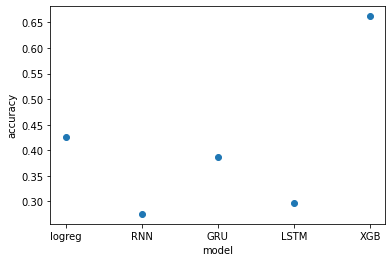

In [112]:
plot_labels, acc_vals = accuracies_allmodels.keys(), accuracies_allmodels.values()

plt.scatter(range(1, len(acc_vals) + 1), acc_vals)
plt.xticks(range(1, len(acc_vals) + 1), plot_labels)
plt.ylabel('accuracy')
plt.xlabel('model')
plt.show()

## results / discussion
- Complicated decision-making behavior can be predicted reasonably well from information encoded in neural activity, even with small and potentially noisy real-world datasets
- Don't want to overinterpret results biologically via differential DNN architectures, but, speculatively, DNNs may be modeling better higher order features such as connectivity, and time dependency 
-   XGBoost appears to be the best performing DNN (67% accuracy vs. 30% expected by chance), perhaps suggesting less local rather than global structure is needed; however, could also be due to simply the nature of dataset with sparse spikes (to address this, can conduct analysis on a different type of data, such as EEG or calcium imaging)
- Interestingly, this suggests cellular information integrated across brain regions may work together for decision-making, a phenomenon that was previously technologically inaccessible


Technical notes:
- appears logistic regression does not perform much better than chance (42% vs. 30%). This could mean previous strangely high accuracy could be overfit d/t outsize influence of noise or outliers, and this was ameliorated as expected with more regularization, crossvalidation. Should validate with other data. 



# Validate RNN further with similated data as described above


Shape: n_trials x n_neurons x n_timebins

In [113]:
# resplit data
split = int(n_trials*4/5)

training_data = neural_recordings[:split]
validation_data = neural_recordings[split:]

training_decisions = decisions[:split]
validation_decisions = decisions[split:]

training_data = np.swapaxes(training_data, 1, 2)
validation_data = np.swapaxes(validation_data, 1, 2)

print("Training input data is of shape", training_data.shape)
print("Validation input data is of shape", validation_data.shape)


Training input data is of shape (200, 50, 10)
Validation input data is of shape (50, 50, 10)


In [116]:
# instantiate the decoder
my_RNN_classifier = decoders.SimpleRNNClassification(units = 50,
                                                    dropout = 0,
                                                    num_epochs =5,
                                                    verbose = 1)

In [117]:
# fit
my_RNN_classifier.fit(training_data, training_decisions)

Epoch 1/5
7/7 [==============================] - 1s 24ms/step - loss: 0.7154 - accuracy: 0.5450
Epoch 2/5
7/7 [==============================] - 0s 26ms/step - loss: 0.6689 - accuracy: 0.5800
Epoch 3/5
7/7 [==============================] - 0s 27ms/step - loss: 0.6561 - accuracy: 0.6250
Epoch 4/5
7/7 [==============================] - 0s 26ms/step - loss: 0.6468 - accuracy: 0.6250
Epoch 5/5
7/7 [==============================] - 0s 24ms/step - loss: 0.6299 - accuracy: 0.6500


In [118]:
# predict
predictions = my_RNN_classifier.predict(validation_data)
predictions

array([1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 1, 1, 0])

In [119]:
#my_RNN_classifier.score(validation_data, validation_decisions)
accuracy = np.sum(predictions == validation_decisions) / len(predictions)
print(accuracy)


0.58


Logistic regression and RNN on simulated data no grossly different, suggesting linear and DNNs implemented here should have no obvious abnormalities, validating in one way.

# Further validate and re-run with other sessions of neuropixels data
As a sanity check, this section will be same analysis as above but on different dataset - different experimental session of same animal.

## load data
This can take about 30 seconds to download the ~600M of data into your working folder, and 10 minutes to run the script.

In [5]:
session = "Cori_2016-12-14/"

!wget -np -r -nv http://data.cortexlab.net/taskData/$session
!mv data.cortexlab.net/taskData/ .

2022-01-12 01:50:57 URL:http://data.cortexlab.net/taskData/Cori_2016-12-14/ [11685] -> "data.cortexlab.net/taskData/Cori_2016-12-14/index.html" [1]
http://data.cortexlab.net/robots.txt:
2022-01-12 01:50:57 ERROR 404: Not Found.
2022-01-12 01:50:57 URL:http://data.cortexlab.net/taskData/Cori_2016-12-14/?C=N;O=D [11685] -> "data.cortexlab.net/taskData/Cori_2016-12-14/index.html?C=N;O=D" [1]
2022-01-12 01:50:57 URL:http://data.cortexlab.net/taskData/Cori_2016-12-14/?C=M;O=A [11685] -> "data.cortexlab.net/taskData/Cori_2016-12-14/index.html?C=M;O=A" [1]
2022-01-12 01:50:57 URL:http://data.cortexlab.net/taskData/Cori_2016-12-14/?C=S;O=A [11685] -> "data.cortexlab.net/taskData/Cori_2016-12-14/index.html?C=S;O=A" [1]
2022-01-12 01:50:57 URL:http://data.cortexlab.net/taskData/Cori_2016-12-14/?C=D;O=A [11685] -> "data.cortexlab.net/taskData/Cori_2016-12-14/index.html?C=D;O=A" [1]
2022-01-12 01:50:57 URL:http://data.cortexlab.net/taskData/Cori_2016-12-14/channels.brainLocation.tsv [19054/19054] 

Now we'll extract this data into Python in the form of a dictionary.

In [6]:
from tqdm import tqdm as tqdm

def load_data(session):
    """Takes a session in relative path ./taskData and loads it as a dictionary."""
    files = !ls taskData/$session/*.npy
    all_files = {}
    for file in files:
        filename = file.split("/")[2][:-4]
        all_files[filename] = np.load(file)
    return all_files
  
def count_neurons(time_interval, all_files):
    """In this time interval, return the neurons with nonzero spikes, and how many
    
    Returns (ids, counts)
    """
    
    
    t1,t2 = time_interval
    
    trial_spikes = all_files['spikes.times']

    interval = (trial_spikes > t1) & (trial_spikes < t2)

    trial_spikes = trial_spikes[interval]
    ids = all_files['spikes.clusters'][interval]
    
    # ids has all the info we need
    return np.unique(ids, return_counts = True)
    
    


def bin_into_array(all_files, time_before_response=1, n_bins = 50):
    
    ids = all_files['spikes.clusters']
    idList = np.unique(ids)
    
    n_trials = len(all_files['trials.response_choice'])
    n_neurons = len(idList)
    
    choices = np.reshape(all_files['trials.response_choice'],-1)
    data = np.zeros((n_trials, n_neurons, n_bins))
    
    time_resolution = time_before_response/ float(n_bins)
    print(time_resolution)
    
    for trial in tqdm(range(n_trials)):
        end_time = all_files['trials.response_times'][trial]
        start_time = end_time - time_before_response
        
        print(time_resolution)
        
        for b in range(n_bins):
        
            which_neurons, n_spikes = count_neurons((start_time + b*time_resolution,
                                            start_time + (b+1)*time_resolution),
                                          all_files)
            
            data[trial,which_neurons,b] = n_spikes
            
    return data, choices


In [7]:
session = "Cori_2016-12-14"
all_files = load_data(session)


In [11]:
binned_spikes_20161214, choices_20161214 = bin_into_array(all_files)
print(binned_spikes_20161214.shape)

0.02


  0%|          | 0/214 [00:00<?, ?it/s]

0.02


  0%|          | 1/214 [00:01<03:58,  1.12s/it]

0.02


  1%|          | 2/214 [00:02<03:52,  1.10s/it]

0.02


  1%|▏         | 3/214 [00:03<03:47,  1.08s/it]

0.02


  2%|▏         | 4/214 [00:04<03:45,  1.07s/it]

0.02


  2%|▏         | 5/214 [00:05<03:43,  1.07s/it]

0.02


  3%|▎         | 6/214 [00:06<03:40,  1.06s/it]

0.02


  3%|▎         | 7/214 [00:07<03:37,  1.05s/it]

0.02


  4%|▎         | 8/214 [00:08<03:35,  1.05s/it]

0.02


  4%|▍         | 9/214 [00:09<03:34,  1.05s/it]

0.02


  5%|▍         | 10/214 [00:10<03:32,  1.04s/it]

0.02


  5%|▌         | 11/214 [00:11<03:30,  1.04s/it]

0.02


  6%|▌         | 12/214 [00:12<03:29,  1.04s/it]

0.02


  6%|▌         | 13/214 [00:13<03:30,  1.05s/it]

0.02


  7%|▋         | 14/214 [00:14<03:31,  1.06s/it]

0.02


  7%|▋         | 15/214 [00:15<03:31,  1.06s/it]

0.02


  7%|▋         | 16/214 [00:16<03:32,  1.07s/it]

0.02


  8%|▊         | 17/214 [00:18<03:35,  1.09s/it]

0.02


  8%|▊         | 18/214 [00:19<03:37,  1.11s/it]

0.02


  9%|▉         | 19/214 [00:20<03:35,  1.10s/it]

0.02


  9%|▉         | 20/214 [00:21<03:33,  1.10s/it]

0.02


 10%|▉         | 21/214 [00:22<03:31,  1.10s/it]

0.02


 10%|█         | 22/214 [00:23<03:27,  1.08s/it]

0.02


 11%|█         | 23/214 [00:24<03:22,  1.06s/it]

0.02


 11%|█         | 24/214 [00:25<03:21,  1.06s/it]

0.02


 12%|█▏        | 25/214 [00:26<03:23,  1.07s/it]

0.02


 12%|█▏        | 26/214 [00:27<03:21,  1.07s/it]

0.02


 13%|█▎        | 27/214 [00:28<03:18,  1.06s/it]

0.02


 13%|█▎        | 28/214 [00:29<03:18,  1.07s/it]

0.02


 14%|█▎        | 29/214 [00:31<03:19,  1.08s/it]

0.02


 14%|█▍        | 30/214 [00:32<03:19,  1.08s/it]

0.02


 14%|█▍        | 31/214 [00:33<03:19,  1.09s/it]

0.02


 15%|█▍        | 32/214 [00:34<03:17,  1.08s/it]

0.02


 15%|█▌        | 33/214 [00:35<03:16,  1.09s/it]

0.02


 16%|█▌        | 34/214 [00:36<03:15,  1.09s/it]

0.02


 16%|█▋        | 35/214 [00:37<03:16,  1.10s/it]

0.02


 17%|█▋        | 36/214 [00:38<03:15,  1.10s/it]

0.02


 17%|█▋        | 37/214 [00:39<03:14,  1.10s/it]

0.02


 18%|█▊        | 38/214 [00:40<03:14,  1.11s/it]

0.02


 18%|█▊        | 39/214 [00:42<03:14,  1.11s/it]

0.02


 19%|█▊        | 40/214 [00:43<03:14,  1.12s/it]

0.02


 19%|█▉        | 41/214 [00:44<03:13,  1.12s/it]

0.02


 20%|█▉        | 42/214 [00:45<03:09,  1.10s/it]

0.02


 20%|██        | 43/214 [00:46<03:08,  1.10s/it]

0.02


 21%|██        | 44/214 [00:47<03:06,  1.10s/it]

0.02


 21%|██        | 45/214 [00:48<03:04,  1.09s/it]

0.02


 21%|██▏       | 46/214 [00:49<03:04,  1.10s/it]

0.02


 22%|██▏       | 47/214 [00:50<03:03,  1.10s/it]

0.02


 22%|██▏       | 48/214 [00:51<03:03,  1.10s/it]

0.02


 23%|██▎       | 49/214 [00:53<03:01,  1.10s/it]

0.02


 23%|██▎       | 50/214 [00:54<02:58,  1.09s/it]

0.02


 24%|██▍       | 51/214 [00:55<02:56,  1.08s/it]

0.02


 24%|██▍       | 52/214 [00:56<02:54,  1.08s/it]

0.02


 25%|██▍       | 53/214 [00:57<02:53,  1.08s/it]

0.02


 25%|██▌       | 54/214 [00:58<02:51,  1.07s/it]

0.02


 26%|██▌       | 55/214 [00:59<02:51,  1.08s/it]

0.02


 26%|██▌       | 56/214 [01:00<02:49,  1.08s/it]

0.02


 27%|██▋       | 57/214 [01:01<02:50,  1.09s/it]

0.02


 27%|██▋       | 58/214 [01:02<02:49,  1.09s/it]

0.02


 28%|██▊       | 59/214 [01:03<02:46,  1.07s/it]

0.02


 28%|██▊       | 60/214 [01:04<02:44,  1.07s/it]

0.02


 29%|██▊       | 61/214 [01:05<02:42,  1.06s/it]

0.02


 29%|██▉       | 62/214 [01:06<02:42,  1.07s/it]

0.02


 29%|██▉       | 63/214 [01:08<02:40,  1.06s/it]

0.02


 30%|██▉       | 64/214 [01:09<02:39,  1.06s/it]

0.02


 30%|███       | 65/214 [01:10<02:37,  1.06s/it]

0.02


 31%|███       | 66/214 [01:11<02:36,  1.06s/it]

0.02


 31%|███▏      | 67/214 [01:12<02:35,  1.06s/it]

0.02


 32%|███▏      | 68/214 [01:13<02:36,  1.07s/it]

0.02


 32%|███▏      | 69/214 [01:14<02:36,  1.08s/it]

0.02


 33%|███▎      | 70/214 [01:15<02:36,  1.08s/it]

0.02


 33%|███▎      | 71/214 [01:16<02:36,  1.10s/it]

0.02


 34%|███▎      | 72/214 [01:17<02:36,  1.10s/it]

0.02


 34%|███▍      | 73/214 [01:18<02:34,  1.10s/it]

0.02


 35%|███▍      | 74/214 [01:19<02:31,  1.09s/it]

0.02


 35%|███▌      | 75/214 [01:21<02:30,  1.08s/it]

0.02


 36%|███▌      | 76/214 [01:22<02:28,  1.07s/it]

0.02


 36%|███▌      | 77/214 [01:23<02:26,  1.07s/it]

0.02


 36%|███▋      | 78/214 [01:24<02:26,  1.07s/it]

0.02


 37%|███▋      | 79/214 [01:25<02:24,  1.07s/it]

0.02


 37%|███▋      | 80/214 [01:26<02:22,  1.07s/it]

0.02


 38%|███▊      | 81/214 [01:27<02:21,  1.06s/it]

0.02


 38%|███▊      | 82/214 [01:28<02:20,  1.07s/it]

0.02


 39%|███▉      | 83/214 [01:29<02:19,  1.06s/it]

0.02


 39%|███▉      | 84/214 [01:30<02:17,  1.06s/it]

0.02


 40%|███▉      | 85/214 [01:31<02:17,  1.06s/it]

0.02


 40%|████      | 86/214 [01:32<02:15,  1.06s/it]

0.02


 41%|████      | 87/214 [01:33<02:14,  1.06s/it]

0.02


 41%|████      | 88/214 [01:34<02:13,  1.06s/it]

0.02


 42%|████▏     | 89/214 [01:35<02:12,  1.06s/it]

0.02


 42%|████▏     | 90/214 [01:36<02:11,  1.06s/it]

0.02


 43%|████▎     | 91/214 [01:37<02:09,  1.05s/it]

0.02


 43%|████▎     | 92/214 [01:38<02:07,  1.05s/it]

0.02


 43%|████▎     | 93/214 [01:40<02:05,  1.04s/it]

0.02


 44%|████▍     | 94/214 [01:41<02:04,  1.04s/it]

0.02


 44%|████▍     | 95/214 [01:42<02:03,  1.04s/it]

0.02


 45%|████▍     | 96/214 [01:43<02:04,  1.05s/it]

0.02


 45%|████▌     | 97/214 [01:44<02:04,  1.06s/it]

0.02


 46%|████▌     | 98/214 [01:45<02:03,  1.06s/it]

0.02


 46%|████▋     | 99/214 [01:46<02:03,  1.08s/it]

0.02


 47%|████▋     | 100/214 [01:47<02:04,  1.09s/it]

0.02


 47%|████▋     | 101/214 [01:48<02:04,  1.11s/it]

0.02


 48%|████▊     | 102/214 [01:49<02:05,  1.12s/it]

0.02


 48%|████▊     | 103/214 [01:50<02:02,  1.10s/it]

0.02


 49%|████▊     | 104/214 [01:51<01:59,  1.09s/it]

0.02


 49%|████▉     | 105/214 [01:53<01:57,  1.08s/it]

0.02


 50%|████▉     | 106/214 [01:54<01:56,  1.07s/it]

0.02


 50%|█████     | 107/214 [01:55<01:54,  1.07s/it]

0.02


 50%|█████     | 108/214 [01:56<01:52,  1.06s/it]

0.02


 51%|█████     | 109/214 [01:57<01:51,  1.06s/it]

0.02


 51%|█████▏    | 110/214 [01:58<01:51,  1.07s/it]

0.02


 52%|█████▏    | 111/214 [01:59<01:49,  1.07s/it]

0.02


 52%|█████▏    | 112/214 [02:00<01:48,  1.06s/it]

0.02


 53%|█████▎    | 113/214 [02:01<01:47,  1.07s/it]

0.02


 53%|█████▎    | 114/214 [02:02<01:46,  1.07s/it]

0.02


 54%|█████▎    | 115/214 [02:03<01:45,  1.07s/it]

0.02


 54%|█████▍    | 116/214 [02:04<01:44,  1.07s/it]

0.02


 55%|█████▍    | 117/214 [02:05<01:43,  1.07s/it]

0.02


 55%|█████▌    | 118/214 [02:06<01:42,  1.07s/it]

0.02


 56%|█████▌    | 119/214 [02:07<01:41,  1.07s/it]

0.02


 56%|█████▌    | 120/214 [02:08<01:40,  1.07s/it]

0.02


 57%|█████▋    | 121/214 [02:10<01:39,  1.07s/it]

0.02


 57%|█████▋    | 122/214 [02:11<01:38,  1.07s/it]

0.02


 57%|█████▋    | 123/214 [02:12<01:37,  1.08s/it]

0.02


 58%|█████▊    | 124/214 [02:13<01:36,  1.08s/it]

0.02


 58%|█████▊    | 125/214 [02:14<01:35,  1.08s/it]

0.02


 59%|█████▉    | 126/214 [02:15<01:34,  1.07s/it]

0.02


 59%|█████▉    | 127/214 [02:16<01:33,  1.08s/it]

0.02


 60%|█████▉    | 128/214 [02:17<01:32,  1.07s/it]

0.02


 60%|██████    | 129/214 [02:18<01:31,  1.07s/it]

0.02


 61%|██████    | 130/214 [02:19<01:30,  1.07s/it]

0.02


 61%|██████    | 131/214 [02:20<01:29,  1.08s/it]

0.02


 62%|██████▏   | 132/214 [02:21<01:28,  1.08s/it]

0.02


 62%|██████▏   | 133/214 [02:23<01:28,  1.09s/it]

0.02


 63%|██████▎   | 134/214 [02:24<01:26,  1.08s/it]

0.02


 63%|██████▎   | 135/214 [02:25<01:25,  1.08s/it]

0.02


 64%|██████▎   | 136/214 [02:26<01:24,  1.08s/it]

0.02


 64%|██████▍   | 137/214 [02:27<01:23,  1.08s/it]

0.02


 64%|██████▍   | 138/214 [02:28<01:21,  1.07s/it]

0.02


 65%|██████▍   | 139/214 [02:29<01:20,  1.07s/it]

0.02


 65%|██████▌   | 140/214 [02:30<01:19,  1.07s/it]

0.02


 66%|██████▌   | 141/214 [02:31<01:17,  1.07s/it]

0.02


 66%|██████▋   | 142/214 [02:32<01:16,  1.07s/it]

0.02


 67%|██████▋   | 143/214 [02:33<01:16,  1.07s/it]

0.02


 67%|██████▋   | 144/214 [02:34<01:15,  1.07s/it]

0.02


 68%|██████▊   | 145/214 [02:35<01:13,  1.07s/it]

0.02


 68%|██████▊   | 146/214 [02:36<01:13,  1.07s/it]

0.02


 69%|██████▊   | 147/214 [02:38<01:11,  1.07s/it]

0.02


 69%|██████▉   | 148/214 [02:39<01:10,  1.07s/it]

0.02


 70%|██████▉   | 149/214 [02:40<01:08,  1.06s/it]

0.02


 70%|███████   | 150/214 [02:41<01:08,  1.07s/it]

0.02


 71%|███████   | 151/214 [02:42<01:07,  1.07s/it]

0.02


 71%|███████   | 152/214 [02:43<01:06,  1.07s/it]

0.02


 71%|███████▏  | 153/214 [02:44<01:05,  1.07s/it]

0.02


 72%|███████▏  | 154/214 [02:45<01:04,  1.07s/it]

0.02


 72%|███████▏  | 155/214 [02:46<01:02,  1.07s/it]

0.02


 73%|███████▎  | 156/214 [02:47<01:01,  1.07s/it]

0.02


 73%|███████▎  | 157/214 [02:48<01:00,  1.07s/it]

0.02


 74%|███████▍  | 158/214 [02:49<00:59,  1.06s/it]

0.02


 74%|███████▍  | 159/214 [02:50<00:58,  1.06s/it]

0.02


 75%|███████▍  | 160/214 [02:51<00:57,  1.06s/it]

0.02


 75%|███████▌  | 161/214 [02:52<00:55,  1.06s/it]

0.02


 76%|███████▌  | 162/214 [02:53<00:55,  1.06s/it]

0.02


 76%|███████▌  | 163/214 [02:55<00:54,  1.07s/it]

0.02


 77%|███████▋  | 164/214 [02:56<00:54,  1.08s/it]

0.02


 77%|███████▋  | 165/214 [02:57<00:53,  1.08s/it]

0.02


 78%|███████▊  | 166/214 [02:58<00:51,  1.07s/it]

0.02


 78%|███████▊  | 167/214 [02:59<00:50,  1.07s/it]

0.02


 79%|███████▊  | 168/214 [03:00<00:49,  1.07s/it]

0.02


 79%|███████▉  | 169/214 [03:01<00:48,  1.08s/it]

0.02


 79%|███████▉  | 170/214 [03:02<00:47,  1.08s/it]

0.02


 80%|███████▉  | 171/214 [03:03<00:46,  1.09s/it]

0.02


 80%|████████  | 172/214 [03:04<00:46,  1.10s/it]

0.02


 81%|████████  | 173/214 [03:06<00:45,  1.12s/it]

0.02


 81%|████████▏ | 174/214 [03:07<00:45,  1.14s/it]

0.02


 82%|████████▏ | 175/214 [03:08<00:44,  1.14s/it]

0.02


 82%|████████▏ | 176/214 [03:09<00:43,  1.15s/it]

0.02


 83%|████████▎ | 177/214 [03:10<00:42,  1.15s/it]

0.02


 83%|████████▎ | 178/214 [03:11<00:41,  1.16s/it]

0.02


 84%|████████▎ | 179/214 [03:13<00:40,  1.15s/it]

0.02


 84%|████████▍ | 180/214 [03:14<00:38,  1.15s/it]

0.02


 85%|████████▍ | 181/214 [03:15<00:38,  1.16s/it]

0.02


 85%|████████▌ | 182/214 [03:16<00:36,  1.15s/it]

0.02


 86%|████████▌ | 183/214 [03:17<00:35,  1.13s/it]

0.02


 86%|████████▌ | 184/214 [03:18<00:33,  1.13s/it]

0.02


 86%|████████▋ | 185/214 [03:19<00:32,  1.13s/it]

0.02


 87%|████████▋ | 186/214 [03:20<00:31,  1.12s/it]

0.02


 87%|████████▋ | 187/214 [03:22<00:30,  1.12s/it]

0.02


 88%|████████▊ | 188/214 [03:23<00:29,  1.12s/it]

0.02


 88%|████████▊ | 189/214 [03:24<00:27,  1.12s/it]

0.02


 89%|████████▉ | 190/214 [03:25<00:26,  1.10s/it]

0.02


 89%|████████▉ | 191/214 [03:26<00:25,  1.10s/it]

0.02


 90%|████████▉ | 192/214 [03:27<00:24,  1.11s/it]

0.02


 90%|█████████ | 193/214 [03:28<00:23,  1.11s/it]

0.02


 91%|█████████ | 194/214 [03:29<00:21,  1.10s/it]

0.02


 91%|█████████ | 195/214 [03:30<00:20,  1.09s/it]

0.02


 92%|█████████▏| 196/214 [03:31<00:19,  1.09s/it]

0.02


 92%|█████████▏| 197/214 [03:32<00:18,  1.09s/it]

0.02


 93%|█████████▎| 198/214 [03:34<00:17,  1.08s/it]

0.02


 93%|█████████▎| 199/214 [03:35<00:15,  1.06s/it]

0.02


 93%|█████████▎| 200/214 [03:36<00:14,  1.06s/it]

0.02


 94%|█████████▍| 201/214 [03:37<00:13,  1.05s/it]

0.02


 94%|█████████▍| 202/214 [03:38<00:12,  1.05s/it]

0.02


 95%|█████████▍| 203/214 [03:39<00:11,  1.04s/it]

0.02


 95%|█████████▌| 204/214 [03:40<00:10,  1.04s/it]

0.02


 96%|█████████▌| 205/214 [03:41<00:09,  1.04s/it]

0.02


 96%|█████████▋| 206/214 [03:42<00:08,  1.05s/it]

0.02


 97%|█████████▋| 207/214 [03:43<00:07,  1.04s/it]

0.02


 97%|█████████▋| 208/214 [03:44<00:06,  1.04s/it]

0.02


 98%|█████████▊| 209/214 [03:45<00:05,  1.05s/it]

0.02


 98%|█████████▊| 210/214 [03:46<00:04,  1.05s/it]

0.02


 99%|█████████▊| 211/214 [03:47<00:03,  1.05s/it]

0.02


 99%|█████████▉| 212/214 [03:48<00:02,  1.05s/it]

0.02


100%|█████████▉| 213/214 [03:49<00:01,  1.04s/it]

0.02


100%|██████████| 214/214 [03:50<00:00,  1.08s/it]

(214, 1085, 50)


In [12]:
#clean up the data we aren't using
!rm -r data.cortexlab.net/

rm: cannot remove 'data.cortexlab.net/': No such file or directory


In [13]:
# dict to store scores
accuracies_allmodels_20161214 = {'logreg': [], 'RNN': [], 'GRU': [], 'LSTM': [], 'XGB': []}

In [14]:
# get training and validation data
(training_Xs, training_Ys), (val_Xs, val_Ys) = mycrossval.get_test_train_splits(binned_spikes_20161214, choices_20161214)

## logistic regression

In [129]:
# 5-fold logistic regression
val_scores = []
for fold in range(5):
    print("Fold {} of 5".format(fold))

    training_X = np.reshape(training_Xs[fold], (len(training_Xs[fold]), -1))
    training_Y = np.reshape(training_Ys[fold], (len(training_Ys[fold]), -1))
    validation_X = np.reshape(val_Xs[fold], (len(val_Xs[fold]), -1))
    validation_Y = np.reshape(val_Ys[fold], (len(val_Ys[fold]), -1)) 

    logreg_model = linear_model.LogisticRegression(penalty='l2',
                                                 solver = 'lbfgs',
                                                 max_iter = 1000,
                                                 C=1e-5)
    # fit and score on training
    logreg_model.fit(training_X, training_Y)
    train_accuracy = logreg_model.score(training_X,training_Y)

    # score on the validation data
    val_accuracy = logreg_model.score(validation_X,validation_Y)
    val_scores.append(val_accuracy)

    print("   training set accuracy of {}".format( train_accuracy ))
    print("   validation set accuracy of {}".format( val_accuracy ))

accuracies_allmodels_20161214['logreg'] = np.mean(val_scores) # store
print("Mean validation accuracy: {}".format(np.mean(val_scores)))


Fold 0 of 5
   training set accuracy of 0.37209302325581395
   validation set accuracy of 0.23809523809523808
Fold 1 of 5
   training set accuracy of 0.38372093023255816
   validation set accuracy of 0.07142857142857142
Fold 2 of 5
   training set accuracy of 0.9767441860465116
   validation set accuracy of 0.6428571428571429
Fold 3 of 5
   training set accuracy of 0.8662790697674418
   validation set accuracy of 0.6428571428571429
Fold 4 of 5
   training set accuracy of 0.5232558139534884
   validation set accuracy of 0.21428571428571427
Mean validation accuracy: 0.3619047619047619


## set params to be used across RNN, GRU, LSTM

In [130]:
units=500
dropout=0.1
num_epochs=10
verbose=1
n_folds = 5


## simple RNN

In [131]:
# double check paths and updated modules (esp. on colab)
%ls
import importlib
importlib.reload(mycrossval)

Binned_data.zip     generate.py                            __pycache__/
binned_spikes.npy   LICENSE                                README.md
choices.npy         mycrossval.py                          taskData/
decoders.py         myplotfns.py
DNN_decoding.ipynb  neural-sequence_transformers_v2.ipynb


<module 'mycrossval' from '/content/drive/My Drive/Colab Notebooks and Projects/neural_activity_models_DNNs-main/mycrossval.py'>

In [132]:
# use training wrapper from mycrossval.py
RNN_model_name = "SimpleRNNClassification" 
all_train_accuracy, all_val_accuracy = mycrossval.kfold_train_wrapper(RNN_model_name, binned_spikes_20161214, choices_20161214,
                                                        n_folds, units, dropout, num_epochs, verbose)
print("all training set accuracy: {}".format(np.mean(all_train_accuracy)))
print("all validation set accuracy: {}".format(np.mean(all_val_accuracy)))
accuracies_allmodels_20161214['RNN'] = np.mean(all_val_accuracy) # store

Fold 0 of 5
Epoch 1/10
6/6 [==============================] - 7s 916ms/step - loss: 0.8976 - accuracy: 0.5814
Epoch 2/10
6/6 [==============================] - 5s 909ms/step - loss: 1.2245 - accuracy: 0.5174
Epoch 3/10
6/6 [==============================] - 5s 894ms/step - loss: 0.7511 - accuracy: 0.4709
Epoch 4/10
6/6 [==============================] - 5s 918ms/step - loss: 0.7457 - accuracy: 0.5465
Epoch 5/10
6/6 [==============================] - 5s 915ms/step - loss: 0.7137 - accuracy: 0.5174
Epoch 6/10
6/6 [==============================] - 5s 899ms/step - loss: 0.7563 - accuracy: 0.4884
Epoch 7/10
6/6 [==============================] - 5s 883ms/step - loss: 0.7163 - accuracy: 0.5349
Epoch 8/10
6/6 [==============================] - 6s 930ms/step - loss: 0.7344 - accuracy: 0.5465
Epoch 9/10
6/6 [==============================] - 5s 908ms/step - loss: 0.7714 - accuracy: 0.4593
Epoch 10/10
6/6 [==============================] - 6s 931ms/step - loss: 0.7004 - accuracy: 0.5872
trainin

## GRU

In [133]:
GRU_model_name = "GRUClassification" 
all_train_accuracy, all_val_accuracy = mycrossval.kfold_train_wrapper(GRU_model_name, binned_spikes_20161214, choices_20161214,
                                    n_folds, units, dropout, num_epochs, verbose)
print("all training set accuracy: {}".format(np.mean(all_train_accuracy)))
print("all validation set accuracy: {}".format(np.mean(all_val_accuracy)))
accuracies_allmodels_20161214['GRU'] = np.mean(all_val_accuracy) # store

Fold 0 of 5
Epoch 1/10
6/6 [==============================] - 19s 3s/step - loss: 0.6791 - accuracy: 0.6163
Epoch 2/10
6/6 [==============================] - 17s 3s/step - loss: 0.6315 - accuracy: 0.6279
Epoch 3/10
6/6 [==============================] - 17s 3s/step - loss: 0.6091 - accuracy: 0.6802
Epoch 4/10
6/6 [==============================] - 17s 3s/step - loss: 0.5626 - accuracy: 0.7151
Epoch 5/10
6/6 [==============================] - 18s 3s/step - loss: 0.5970 - accuracy: 0.7442
Epoch 6/10
6/6 [==============================] - 17s 3s/step - loss: 0.3760 - accuracy: 0.8721
Epoch 7/10
6/6 [==============================] - 17s 3s/step - loss: 0.4275 - accuracy: 0.8140
Epoch 8/10
6/6 [==============================] - 17s 3s/step - loss: 0.4477 - accuracy: 0.7674
Epoch 9/10
6/6 [==============================] - 17s 3s/step - loss: 0.3964 - accuracy: 0.8314
Epoch 10/10
6/6 [==============================] - 17s 3s/step - loss: 0.3356 - accuracy: 0.8837
training fold accuracy: 0.4

## LSTM

In [134]:
LSTM_model_name = "LSTMClassification" 
all_train_accuracy, all_val_accuracy = mycrossval.kfold_train_wrapper(LSTM_model_name, binned_spikes_20161214, choices_20161214,
                                        n_folds, units, dropout, num_epochs, verbose)
print("all training set accuracy: {}".format(np.mean(all_train_accuracy)))
print("all validation set accuracy: {}".format(np.mean(all_val_accuracy)))
accuracies_allmodels_20161214['LSTM'] = np.mean(all_val_accuracy) # store

Fold 0 of 5
Epoch 1/10
6/6 [==============================] - 20s 3s/step - loss: 0.6971 - accuracy: 0.5756
Epoch 2/10
6/6 [==============================] - 18s 3s/step - loss: 0.6510 - accuracy: 0.6395
Epoch 3/10
6/6 [==============================] - 18s 3s/step - loss: 0.6091 - accuracy: 0.6686
Epoch 4/10
6/6 [==============================] - 18s 3s/step - loss: 0.5890 - accuracy: 0.6686
Epoch 5/10
6/6 [==============================] - 18s 3s/step - loss: 0.6272 - accuracy: 0.6919
Epoch 6/10
6/6 [==============================] - 18s 3s/step - loss: 0.5915 - accuracy: 0.7442
Epoch 7/10
6/6 [==============================] - 18s 3s/step - loss: 0.5255 - accuracy: 0.8314
Epoch 8/10
6/6 [==============================] - 18s 3s/step - loss: 0.5185 - accuracy: 0.7384
Epoch 9/10
6/6 [==============================] - 18s 3s/step - loss: 0.3523 - accuracy: 0.8663
Epoch 10/10
6/6 [==============================] - 18s 3s/step - loss: 0.3572 - accuracy: 0.8430
training fold accuracy: 0.4

## XGBoost
XGBoost is powerful but does not model time dependencies, thus have to flatten and obtain new splits

Unable to find label for choices: [-1, 0, 1] in this dataset vs. previously, [0, 1, 2], so will add one to see if it works. Initial comparison of train set vs. validation set accuracy should control for this. If we need to look at choice-specific decoding downstream, we will reassess. 

In [20]:
binned_spikes_20161214_flat = np.reshape(binned_spikes_20161214, (len(binned_spikes_20161214),-1)) # keep first dim, flatten rest

(training_X, training_Y), (validation_X, validation_Y) = mycrossval.get_test_train_splits(binned_spikes_20161214_flat, choices_20161214 + 1)

n_folds = 5
accuracies = []
for fold in range(n_folds):
 
  print(f"Fold {fold} of {n_folds}")
  train_Xi = training_X[fold]
  train_Yi = training_Y[fold]
  val_Xi = validation_X[fold]
  val_Yi = validation_Y[fold]

  XGBoost_classifier = decoders.XGBoostClassification()
  XGBoost_classifier.fit(train_Xi, train_Yi)

  # calc accuracy
  predictions = XGBoost_classifier.predict(val_Xi)
  accuracy = np.sum(predictions == val_Yi) / len(predictions)
  accuracies.append(accuracy)
  print(accuracy)

accuracies_allmodels_20161214['XGB'] = np.mean(accuracies) # store

Fold 0 of 5
0.8095238095238095
Fold 1 of 5
0.8809523809523809
Fold 2 of 5
0.8571428571428571
Fold 3 of 5
0.9761904761904762
Fold 4 of 5
0.8333333333333334


## plot all accuracies
Plot superimposed with results above to compare

In [28]:
# optional re-import metrics from previous to avoid-retraining
# dict to store scores
accuracies_allmodels_20161218 = {'logreg': 0.42, 'RNN': 0.27, 'GRU': 0.38, 'LSTM': 0.29, 'XGB': 0.66}
accuracies_allmodels_20161214 = {'logreg': 0.36, 'RNN': 0.34, 'GRU': 0.33, 'LSTM': 0.38, 'XGB': 0.87}


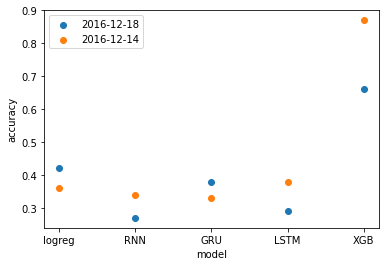

In [30]:
plot_labels_20161218, acc_vals_20161218 = accuracies_allmodels_20161218.keys(), accuracies_allmodels_20161218.values()
plot_labels_20161214, acc_vals_20161214 = accuracies_allmodels_20161214.keys(), accuracies_allmodels_20161214.values()


plt.scatter(range(1, len(acc_vals_20161218) + 1), acc_vals_20161218)
plt.scatter(range(1, len(acc_vals_20161214) + 1), acc_vals_20161214)

plt.xticks(range(1, len(acc_vals_20161218) + 1), plot_labels_20161218)
plt.ylabel('accuracy')
plt.xlabel('model')
plt.legend(['2016-12-18', '2016-12-14'])
plt.show()

## results / discussion
- Similar trends as noted above, validating in another way
- Interestingly, XGB appears to again outperform other methods 
- Unclear whether other DNNs outperform, comparisons inappropriate at this stage
-Don't want to overinterpret results biologically via differential DNN architectures, but, speculatively, if XGB outperforms it may suggest that time dependencies and hidden states may play a less important role in brain-wide dynamics as captured here
- Further analysis on whether longitudinal sessions shows decoding plasticity could be interesting



# Future directions:
- expand dataset
- more systmatic hyperparameter tuning, e.g. grid search
- compare with other models, e.g. KNNs, SVM
- generalize to other types of data and conditions, such as EEG data in decision-making tasks
- prediction of real-time dynamics and how this may affect the performance of DNNs, e.g. less structural and more sequential information
